In [263]:
import pandas

Import the dataset

In [264]:
dataset = pandas.read_csv("test.csv")

Show the first entries and columns

In [265]:
dataset.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km),Density (P/Km)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [266]:
dataset.count()

textID              3534
text                3534
sentiment           3534
Time of Tweet       3534
Age of User         3534
Country             3534
Population -2020    3534
Land Area (Km)      3534
Density (P/Km)      3534
dtype: int64

Drop unnecessary information

In [267]:
dataset = dataset.drop(["Land Area (Km)", "Density (P/Km)", "Age of User", "Country", "Population -2020", "Time of Tweet"], axis=1)
dataset.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


As we can see, in the columns "textID", "text" and "sentiment" we have some "NaN" values. Remove all rows with "NaN" in the "textID"

In [268]:
dataset = dataset[dataset["textID"].notna()]
dataset.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


Map "sentiment" to integers

In [269]:
classes = {"negative": 0, "neutral": 1, "positive": 2}
dataset["sentiment"] = dataset["sentiment"].map(classes)
dataset.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,1
1,96d74cb729,Shanghai is also really exciting (precisely -...,2
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0
3,01082688c6,happy bday!,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,2


Tokenize the texts:

In [270]:
import tiktoken

Create an encoding for "gpt-3.5-turbo".

In [271]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

Test the encoding

In [272]:
assert encoding.encode("Hello world!") == [9906, 1917, 0]


Map all texts to tokens

In [273]:
dataset["text"] = dataset["text"].map(lambda text: encoding.encode(text))

In [274]:
dataset.head()

,textID,text,sentiment
0,f87dea47db,"[5966, 3882, 315, 279, 1938, 220, 1795, 1129, ...",1
1,96d74cb729,"[38147, 374, 1101, 2216, 13548, 320, 10872, 28...",2
2,eee518ae67,"[697, 26540, 4295, 6383, 263, 2428, 77018, 447...",0
3,01082688c6,"[6380, 293, 1316, 0]",2
4,33987a8ee5,"[1795, 1129, 15930, 275, 15959, 916, 14, 19, 8...",2


Analyse the lengths of the tokenized texts

<Axes: >

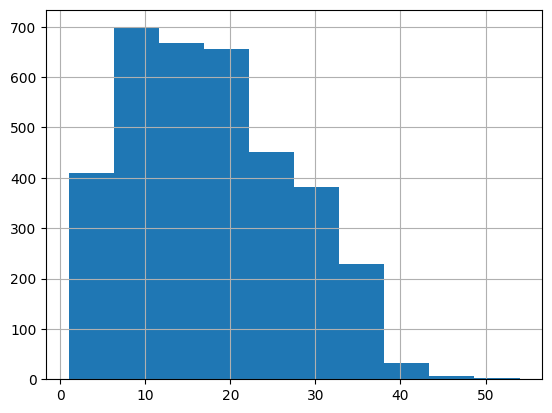

In [275]:
dataset["text"].map(lambda text: len(text)).hist()

Find the maximum length to retrieve the number of model inputs:

In [276]:
dataset["text"].map(lambda text: len(text)).max()

54

So we learned, that the longest text has a length of 54 tokens. We could use this as the number of inputs for our model. Thus we can not use this exact model for other datasets since the length of tokenized texts may be too big for our model.

1 token ~ 3/4 of a word
        ~ 4 characters

So 54 tokens are around 40 words in an average well-written english text.

We will set the expected inputs to 50 words which are approximately 67 tokens. If we receive longer inputs in the future we will split the texts and persist which texts belong together.

---

Create the pytorch model:

In [277]:
import os
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import lightning as L

In [278]:

# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(
    nn.Linear(67, 64), 
    nn.ReLU(), 
    nn.Linear(64, 32), 
    nn.ReLU(), 
    nn.Linear(32,16), 
    nn.ReLU(),
    nn.Linear(16,8), 
    nn.ReLU(),
    nn.Linear(8,4), 
    nn.ReLU()
)
decoder = nn.Sequential(
    nn.Linear(4,8), 
    nn.ReLU(),
    nn.Linear(8,16), 
    nn.ReLU(),
    nn.Linear(16, 32), 
    nn.ReLU(), 
    nn.Linear(32, 64), 
    nn.Sigmoid(), 
    nn.Linear(64,1)
)


# define the LightningModule
class SentimentModel(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input):
        return self.decoder(self.encoder(input))

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch

        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, y)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch

        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.cross_entropy(input=x_hat, target=y)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# init the autoencoder
sentiment_model = SentimentModel(encoder, decoder)

We will use the "DataLoader" of "PyTorch Lightning". Therefore we will need a numpy tensor:

In [279]:
import numpy

In [280]:
number_of_tokens=67

In [281]:
def fill_missing_elements(list):
    list_ = list + (number_of_tokens - len(list)) * [0]
    return numpy.array(list_).reshape(67, 1)

In [282]:
input_tensor = dataset.filter(["text"]).map(lambda list: fill_missing_elements(list)).to_numpy()

flattened_array = numpy.array([inner_array.flatten() for inner_array in input_tensor[:, 0]])
print(flattened_array)
print(flattened_array.shape)

[[ 5966  3882   315 ...     0     0     0]
 [38147   374  1101 ...     0     0     0]
 [  697 26540  4295 ...     0     0     0]
 ...
 [  358  1440  1148 ...     0     0     0]
 [  646 78981  1148 ...     0     0     0]
 [ 1795  1129 15930 ...     0     0     0]]
(3534, 67)


As we can see on our second dimension of the input tensor we have lists. We have to flatten those lists so we receive a tensor of the shape (3534, 67) which was our initial token length. If a list does not have enough tokens, we will append the rest with the value "0".

Also create the tensor for the neural network outputs:

In [283]:
output_tensor = dataset.filter(["sentiment"]).to_numpy()
print(f"ndim={output_tensor.ndim}")
print(f"shape={output_tensor.shape}")
print()
print(output_tensor)

ndim=2
shape=(3534, 1)

[[1]
 [2]
 [0]
 ...
 [0]
 [2]
 [2]]


Create a custom dataset:

In [284]:
import torch
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        output_sample = self.outputs[idx]

        return torch.Tensor(input_sample), torch.Tensor(output_sample)
#        return {'input': torch.Tensor(input_sample), 'output': torch.Tensor(output_sample)}


Create a data module

In [285]:
import pytorch_lightning as pl

class SentimentDataModule(pl.LightningDataModule):
    def __init__(self, train_inputs, train_outputs, val_inputs, val_outputs, batch_size=32):
        super().__init__()
        self.train_dataset = SentimentDataset(train_inputs, train_outputs)
        self.val_dataset = SentimentDataset(val_inputs, val_outputs)
        self.batch_size = batch_size

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size)


In [286]:
flattened_array

array([[ 5966,  3882,   315, ...,     0,     0,     0],
       [38147,   374,  1101, ...,     0,     0,     0],
       [  697, 26540,  4295, ...,     0,     0,     0],
       ...,
       [  358,  1440,  1148, ...,     0,     0,     0],
       [  646, 78981,  1148, ...,     0,     0,     0],
       [ 1795,  1129, 15930, ...,     0,     0,     0]])

Train/Validation split:

In [287]:
train_datamodule = SentimentDataModule(flattened_array[70:, :], output_tensor[70:], flattened_array[:70, :], output_tensor[:70, :])

Train the model

In [288]:
trainer = L.Trainer(max_epochs=500, accelerator="gpu")
trainer.fit(sentiment_model, train_datamodule.train_dataloader())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\MarcoSteinke\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 7.1 K 
1 | decoder | Sequential | 2.9 K 
---------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)
c:\Users\MarcoSteinke\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


In [289]:
#trainer.validate(sentiment_model, train_datamodule.val_dataloader())
trainer.logged_metrics

{'train_loss': tensor(0.4494)}

We achieved a loss of under 5% which is okay for this naive model.

Helper function to tokenize inputs and prepare them for the model:

In [290]:
def prepare_input(text):
    tokens = encoding.encode(text)
    return fill_missing_elements(tokens)

In [291]:
text = "This looks nice."

In [292]:
assert prepare_input(text).shape == (number_of_tokens, 1)

In [293]:
input = prepare_input(text)

sentiment_model(input)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray